In [2]:
import pandas as pd
import numpy as np
from pulp import *
import matplotlib.pyplot as plt
import csv
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import seaborn as sns

In [3]:
df = pd.read_excel("data-nutri-score-project.xlsx")

In [4]:
# def score_to_numeric(score):
#     mapping = {'a': 5, 'a-plus': 5, 'b': 4, 'c': 3, 'd': 2, 'e': 1}
#     return mapping[score]

In [5]:
# df['nutri_numeric'] = df['Nutri-Score'].apply(score_to_numeric)
# df['eco_numeric'] = df['Eco-Score'].apply(score_to_numeric)

In [6]:
# eco_score_ranges = {
#     'a-plus': (90, 100),
#     'a': (80, 89),
#     'b': (60, 79),
#     'c': (40, 59),
#     'd': (20, 39),
#     'e': (0, 19)
# }

# def get_random_eco_score(category):
#     if category in eco_score_ranges:
#         return np.random.randint(*eco_score_ranges[category])
    
# df['Eco-Score-Value'] = df['Eco-Score'].apply(get_random_eco_score)

# output_file = "data-nutri-score-project.xlsx"
# df.to_excel(output_file, index=False)

### *Normalization*

In [7]:
min_nutri = df['Nutri-Score-Value'].min(axis=0)
max_nutri = df['Nutri-Score-Value'].max(axis=0)

min_eco = df['Eco-Score-Value'].min(axis=0)
max_eco = df['Eco-Score-Value'].max(axis=0)

df["Normalized-Nutri-Score"] = (df["Nutri-Score-Value"] - min_nutri) / (max_nutri - min_nutri)
df["Normalized-Eco-Score"] = (df["Eco-Score-Value"] - min_eco) / (max_eco - min_eco)

df[['Product Name','Nutri-Score', 'Normalized-Nutri-Score', 'Eco-Score', 'Normalized-Eco-Score']]


,Product Name,Nutri-Score,Normalized-Nutri-Score,Eco-Score,Normalized-Eco-Score
0,cruesly mélange de noix,a,0.142857,b,0.767677
1,Céréales Chocapic,a,0.285714,e,0.101010
2,Flocons d'avoine,a,0.071429,a,0.848485
3,Haferflocken,a,0.071429,a,0.878788
4,Weetabix,a,0.142857,e,0.101010
...,...,...,...,...,...
938,All-bran,a,0.107143,e,0.070707
939,All-Bran Original,b,0.428571,e,0.070707
940,Clusters,c,0.571429,e,0.010101
941,Bamboo,a,0.178571,b,0.737374


### 1. Frist option: Weighted sum

In [8]:
w1 = 0.6  # Nutri-Score weight
w2 = 0.4  # Eco-Score weight

df['weighted_sum_utility'] = - w1 * df['Normalized-Nutri-Score'] + w2 * df['Normalized-Eco-Score']
df[['Product Name','Nutri-Score', 'Eco-Score', 'weighted_sum_utility']]

df = df.sort_values(by="weighted_sum_utility", ascending=False)

df[['Product Name','Nutri-Score', 'Eco-Score', 'weighted_sum_utility']]

,Product Name,Nutri-Score,Eco-Score,weighted_sum_utility
72,bio organic oat flakes,a,a-plus,0.358369
81,Organic Porridge Oats,a,a-plus,0.358369
510,Flocons d'Epeautre,a,a-plus,0.342208
883,Fiocchi di avena,a,a-plus,0.340981
656,Hafer Flocken zart,a,a-plus,0.340981
...,...,...,...,...
429,Trésor chocolat noisettes,d,e,-0.492857
405,Céréales Trésor Kellogg's Chocolat Lait - 1kg,d,e,-0.498124
934,Extra choccolato al latte,d,e,-0.502165
466,Kellogg's Frosties,d,e,-0.502165


In [9]:
def classify(score):
    if score > 0.3:
        return "Excellent"
    elif score > 0:
        return "Good"
    else:
        return "Poor"

df["Classification"] = df["weighted_sum_utility"].apply(classify)
df_opt_1 = df[['Product Name','Nutri-Score', 'Eco-Score', 'weighted_sum_utility', 'Classification']]
df_opt_1

,Product Name,Nutri-Score,Eco-Score,weighted_sum_utility,Classification
72,bio organic oat flakes,a,a-plus,0.358369,Excellent
81,Organic Porridge Oats,a,a-plus,0.358369,Excellent
510,Flocons d'Epeautre,a,a-plus,0.342208,Excellent
883,Fiocchi di avena,a,a-plus,0.340981,Excellent
656,Hafer Flocken zart,a,a-plus,0.340981,Excellent
...,...,...,...,...,...
429,Trésor chocolat noisettes,d,e,-0.492857,Poor
405,Céréales Trésor Kellogg's Chocolat Lait - 1kg,d,e,-0.498124,Poor
934,Extra choccolato al latte,d,e,-0.502165,Poor
466,Kellogg's Frosties,d,e,-0.502165,Poor


### 2. Second option: Sorting model
We can define decision rules or sorting thresholds to categorize products based on their Nutri-Score and Eco-Score values. This approach avoids assigning arbitrary weights and instead applies a set of predefined rules to determine the category.
We chose a sorting model, such that:
* Criteria:
Nutri-Score Value
Eco-Score Value
* Categories:
Categories like Excellent, Good, Poor.
* Boundary profiles:
define the transitions between these categories.
* Weights:
Assign relative importance to Nutri-Score and Eco-Score.

In [10]:
weights = {
    "Normalized-Nutri-Score": 0.6,  # Nutri-Score weight
    "Normalized-Eco-Score": 0.4     # Eco-Score weight
}
# Determine thresholds using quantiles
nutri_score_terciles = df['Normalized-Nutri-Score'].quantile([1/3, 2/3]).values
eco_score_terciles = df['Normalized-Eco-Score'].quantile([1/3, 2/3]).values

limiting_profiles = {
    'Excellent': {
        'Normalized-Nutri-Score': nutri_score_terciles[1],  # Top 66.7% to 100%
        'Normalized-Eco-Score': eco_score_terciles[1]
    },
    'Good': {
        'Normalized-Nutri-Score': nutri_score_terciles[0],  # Top 33.3% to 66.7%
        'Normalized-Eco-Score': eco_score_terciles[0]
    },
    'Poor': {
        'Normalized-Nutri-Score': df['Normalized-Nutri-Score'].min(),  # Bottom 0% to 33.3%
        'Normalized-Eco-Score': df['Normalized-Eco-Score'].min()
    }
}

limiting_profiles

{'Excellent': {'Normalized-Nutri-Score': 0.39285714285714285,
  'Normalized-Eco-Score': 0.707070707070706},
 'Good': {'Normalized-Nutri-Score': 0.21428571428571427,
  'Normalized-Eco-Score': 0.2727272727272727},
 'Poor': {'Normalized-Nutri-Score': 0.0, 'Normalized-Eco-Score': 0.0}}

In [11]:
# Threshold for concordance
lambda_threshold = 0.6

def compute_concordance(item, profile, weights):
    """
    Computes the concordance index for a given item against a profile.
    """
    concordance = 0
    for criterion, value in profile.items():
        if item[criterion] <= value:
            concordance += weights[criterion]
    return concordance

def pessimistic_majority_sorting(item, profiles, weights, lambda_threshold):
    """
    Assigns a category to an item using the pessimistic sorting rule.
    """
    for category, profile in sorted(profiles.items()): 
        concordance = compute_concordance(item, profile, weights)
        if concordance >= lambda_threshold:
            return category
    return "Poor"

df["Pessimistic_Category"] = df.apply(
    lambda row: pessimistic_majority_sorting(row, limiting_profiles, weights, lambda_threshold), axis=1
)

df_opt_2 = df[['Product Name','Nutri-Score', 'Eco-Score', 'Pessimistic_Category']]
df_opt_2

,Product Name,Nutri-Score,Eco-Score,Pessimistic_Category
72,bio organic oat flakes,a,a-plus,Excellent
81,Organic Porridge Oats,a,a-plus,Excellent
510,Flocons d'Epeautre,a,a-plus,Excellent
883,Fiocchi di avena,a,a-plus,Excellent
656,Hafer Flocken zart,a,a-plus,Excellent
...,...,...,...,...
429,Trésor chocolat noisettes,d,e,Poor
405,Céréales Trésor Kellogg's Chocolat Lait - 1kg,d,e,Poor
934,Extra choccolato al latte,d,e,Poor
466,Kellogg's Frosties,d,e,Poor


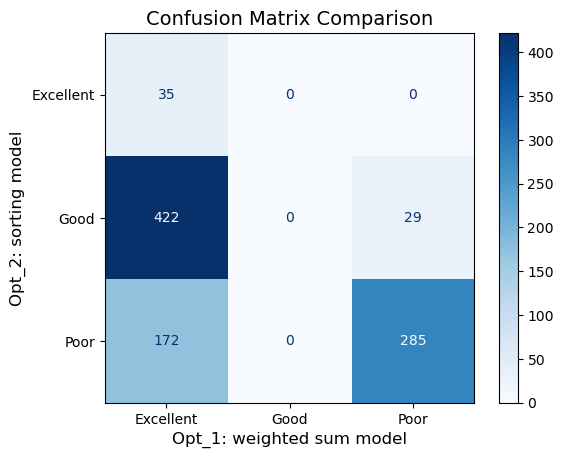

In [13]:
labels = sorted(df_opt_1['Classification'].unique())  # Ensures consistent label ordering
cm = confusion_matrix(df_opt_1['Classification'], df_opt_2['Pessimistic_Category'], labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap="Blues")

plt.xlabel('Opt_1: weighted sum model', fontsize=12)
plt.ylabel('Opt_2: sorting model', fontsize=12)
plt.title('Confusion Matrix Comparison', fontsize=14)

plt.show()
